In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import multivariate_normal

from torch.autograd import Variable
from utls import *
from torchsummary import *
from tqdm import tqdm_notebook as tqdm


hyper parameters

In [14]:
lr = 0.001
lr_step = 20
lr_decay = 0.8
n_epoch = 200
n_batch = 32
n_class = 2
n_noise_fea = 2
img_size = (3, 128, 128)
log_file = 'test_GAN_2_class'
device_name = 'cuda:0'
seed = 1

torch.cuda.set_device(device_name)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device=torch.device(device_name)
torch.cuda.manual_seed(seed)

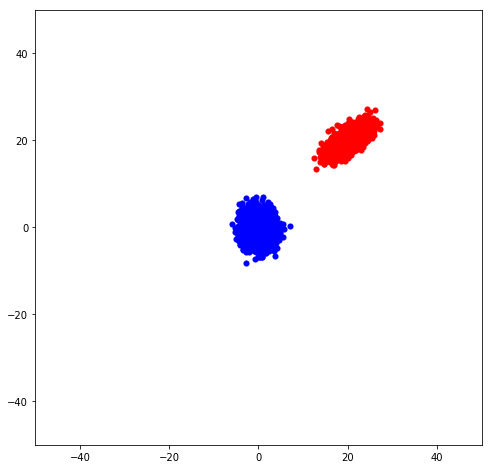

In [15]:
X_train1 = np.random.multivariate_normal([0, 0], [[3, 0], [0, 5]], 2000)
X_train2 = np.random.multivariate_normal([20, 20], [[5, 3], [3, 4]], 2000)
Y1 = 0 * np.ones(2000)
Y2 = 1 * np.ones(2000)

X_in = np.concatenate([X_train1, X_train2])
Y_in = np.concatenate([Y1, Y2])
Y = np.zeros(4000)
Y_in = np.column_stack((Y_in, Y))
plt.figure(figsize=[8,8])
plt.ylim(-50, 50)
plt.xlim(-50, 50)
plt.scatter(X_train1[:,0], X_train1[:,1], c='b', linewidth=0.1)
plt.scatter(X_train2[:,0], X_train2[:,1], c='r', linewidth=0.1)

In [16]:
X_test = np.random.uniform(low=[-50, -50], high=[50, 50], size=(5000,2))
Y_test = 0 * np.ones((5000, 2))

In [17]:
class dataload(TensorDataset):
    """Customized dataset loader"""
    def __init__(self, mode):

        if(mode == 'test'):
            self.data = X_test
            self.labels = Y_test
        else:
            self.data = np.concatenate([X_in])
            self.labels = np.concatenate([Y_in])
        self.labels = self.labels.astype(np.long)

    def __len__(self):
        return (self.data.shape[0])

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx][0]
        return data, labels

In [18]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

class DiscriminatorNet(torch.nn.Module):
    """
    A two hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 500),
            nn.LeakyReLU(0.2),
            nn.Linear(500, 500),
            nn.LeakyReLU(0.2),
#             nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.Linear(500, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.out(x)
        return x
    
class GeneratorNet(torch.nn.Module):
    """
    A two hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = n_noise_fea
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(500, n_out),
#             nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.out(x)
        return x
    
class twohiddenNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(twohiddenNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, num_classes),
#             nn.Softmax(dim=-1),
        )
    def forward(self, x):
        out = self.layers(x)
        return out

In [19]:
class Trainer():
    def __init__(self, generator, discriminator, predictor, num_classes = 2):
        
        self.N = 100 #batch_size
        self.num_classes = num_classes
        self.beta = 5
        
        self.discriminator = discriminator
        self.generator = generator
        self.predictor = predictor
        self.discriminator.train()
        self.generator.train()
        self.predictor.train()
        
        self.loss = nn.BCELoss()
        self.out_dist_loss = nn.KLDivLoss(reduction='batchmean')
        self.in_dist_loss = nn.NLLLoss()
        
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0001)
        self.p_optimizer = torch.optim.Adam(self.predictor.parameters(), lr=0.0001)
        
        self.predictor.load_state_dict(torch.load('logs/_pre_init.pt'))
        self.predictor.eval()
        
    
    def noise(self, size):
        '''
        Generates a 1-d vector of gaussian sampled random values
        '''
        n = torch.randn(size, n_noise_fea)
        return n
        
    def train_discriminator(self, real_data):
        N = real_data.size(0)
        self.d_optimizer.zero_grad()
        smothness = 0
        # 1.1 Train on Real Data
        prediction_real = self.discriminator(real_data)
        # Calculate error and backpropagate
        error_real = self.loss(prediction_real, torch.ones(N, 1) - smothness)
        
        # 1.2 Train on Fake Data
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = self.generator(self.noise(self.N))
        prediction_fake = self.discriminator(fake_data.detach())
        # Calculate error and backpropagate
        error_fake = self.loss(prediction_fake, torch.zeros(self.N, 1) + smothness)
        err = error_real + error_fake
        err.backward()
        # 1.3 Update weights with gradients
        self.d_optimizer.step()

        return err, prediction_real, prediction_fake

    def train_generator(self):
        
        self.g_optimizer.zero_grad()
        # 1.1 Train on fake data
        # Sample noise and generate fake data
        fake_data = self.generator(self.noise(self.N))
        prediction = self.discriminator(fake_data)
        # Calculate error and backpropagate
        error = self.loss(prediction, torch.ones(self.N, 1))
        
        #1.2 Train KL divergence on Fake Data
        output = self.predictor(fake_data)
        output = F.log_softmax(output, dim=-1)
        uniform_dist = torch.Tensor(output.size(0), self.num_classes).fill_((1./self.num_classes))
        error_KL = self.out_dist_loss(output, uniform_dist)
           
        err = (self.beta * error_KL + error)/(1 + self.beta)
        err.backward()
        # Update weights with gradients
        self.g_optimizer.step()
        # Return error
        return err
    
    def train_predictor(self, real_data, cls):

        self.p_optimizer.zero_grad()
       
        # 1.1 Train on Real Data
        prediction = self.predictor(real_data)
        
        # Calculate error and backpropagate
        prediction = F.log_softmax(prediction, dim=-1)
        error_real = self.in_dist_loss(prediction, 1 - cls)
        
        # 1.2 Train KL divergence on Fake Data
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = self.generator(self.noise(self.N))
        output = self.predictor(fake_data.detach())
        output = F.log_softmax(output, dim=-1)
        uniform_dist = torch.Tensor(output.size(0), self.num_classes).fill_((1./self.num_classes)).cuda()
        error_KL = self.out_dist_loss(output, uniform_dist)
        
        err = (error_KL + error_real)
        err.backward()
        # 1.3 Update weights with gradients
        self.p_optimizer.step()

        return err, prediction, output


In [20]:
Train_data = dataload(mode = 'train')
Train_dataloader = DataLoader(dataset=Train_data, batch_size = 100, shuffle=True)

In [21]:
_discriminator = DiscriminatorNet().to(device)
_generator = GeneratorNet().to(device)
_predictor = twohiddenNet().to(device)

train_data, _, = next(iter(Train_dataloader))
print("Discriminator")
summary(_discriminator, input_size= train_data[0].size())
print("Generator")
summary(_generator, input_size= torch.Size([n_noise_fea]))
print("Predictor")
summary(_predictor, input_size= train_data[0].size())

Discriminator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]           1,500
         LeakyReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 500]         250,500
         LeakyReLU-4                  [-1, 500]               0
            Linear-5                    [-1, 1]             501
           Sigmoid-6                    [-1, 1]               0
Total params: 252,501
Trainable params: 252,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.96
Estimated Total Size (MB): 0.98
----------------------------------------------------------------
Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linea

In [22]:
logger = GAN_Logger(_generator, _discriminator, _predictor, file_name=log_file, num_classes=n_class)
trainer = Trainer(_generator, _discriminator, _predictor, num_classes=n_class)
    
fix_noises = Variable(torch.randn(500, n_noise_fea))
# Total number of epochs to train
p_error = torch.rand(1)
for epoch in range(1, n_epoch + 1):
    print("[%d/%d]"%(epoch, n_epoch))
    for real_batch, real_label in tqdm(Train_dataloader):
        real_batch = real_batch.to(device).float()
        real_label = real_label.to(device).long()
       
        real_data = Variable(real_batch)
        cls = Variable(real_label)
        
        # 1. Train Discriminator
        d_error, d_pred_real, d_pred_fake = trainer.train_discriminator(real_data)

        # 2. Train Generator
        g_error = trainer.train_generator()
        
#         3. Train Predictor
#         if(epoch % 2 == 0):
#             p_error, p_real, p_fake = trainer.train_predictor(real_data, cls)
        
        logger.batch_update(gen_loss = g_error, dis_loss = d_error, pre_loss = p_error)
        
    with torch.no_grad():
        fake_data = _generator(fix_noises).detach()
        fake_img = fake_data.cpu().data
        logger.epoch_update(epoch=epoch)

Setting up a new session...
Setting up a new session...


[1/200]



generator loss : 12.0770, discriminator loss : 0.7442, predictor loss  0.3798
[2/200]



generator loss : 3.0677, discriminator loss : 0.2359, predictor loss  0.3798
[3/200]



generator loss : 0.8493, discriminator loss : 0.0903, predictor loss  0.3798
[4/200]



generator loss : 0.9256, discriminator loss : 0.0523, predictor loss  0.3798
[5/200]



generator loss : 1.0344, discriminator loss : 0.0395, predictor loss  0.3798
[6/200]



generator loss : 1.0430, discriminator loss : 0.0352, predictor loss  0.3798
[7/200]



generator loss : 1.1074, discriminator loss : 0.0428, predictor loss  0.3798
[8/200]



generator loss : 1.2046, discriminator loss : 0.0790, predictor loss  0.3798
[9/200]



generator loss : 1.0959, discriminator loss : 0.3272, predictor loss  0.3798
[10/200]



generator loss : 0.7742, discriminator loss : 0.4766, predictor loss  0.3798
[11/200]



generator loss : 0.6183, discriminator loss : 0.4601, predictor loss  0.3798
[12/200]



generator loss : 0.5730, discriminator loss : 0.2999, predictor loss  0.3798
[13/200]



generator loss : 0.5818, discriminator loss : 0.2296, predictor loss  0.3798
[14/200]



generator loss : 0.5996, discriminator loss : 0.1780, predictor loss  0.3798
[15/200]



generator loss : 0.6171, discriminator loss : 0.1504, predictor loss  0.3798
[16/200]



generator loss : 0.6383, discriminator loss : 0.1252, predictor loss  0.3798
[17/200]



generator loss : 0.6605, discriminator loss : 0.1027, predictor loss  0.3798
[18/200]



generator loss : 0.6771, discriminator loss : 0.0942, predictor loss  0.3798
[19/200]



generator loss : 0.6833, discriminator loss : 0.0793, predictor loss  0.3798
[20/200]



generator loss : 0.7103, discriminator loss : 0.0712, predictor loss  0.3798
[21/200]



generator loss : 0.7424, discriminator loss : 0.0663, predictor loss  0.3798
[22/200]



generator loss : 0.7486, discriminator loss : 0.0603, predictor loss  0.3798
[23/200]



generator loss : 0.7667, discriminator loss : 0.0589, predictor loss  0.3798
[24/200]



generator loss : 0.7797, discriminator loss : 0.0548, predictor loss  0.3798
[25/200]



generator loss : 0.7997, discriminator loss : 0.0539, predictor loss  0.3798
[26/200]



generator loss : 0.8283, discriminator loss : 0.0525, predictor loss  0.3798
[27/200]



generator loss : 0.8365, discriminator loss : 0.0494, predictor loss  0.3798
[28/200]



generator loss : 0.8546, discriminator loss : 0.0477, predictor loss  0.3798
[29/200]



generator loss : 0.8711, discriminator loss : 0.0453, predictor loss  0.3798
[30/200]



generator loss : 0.8922, discriminator loss : 0.0419, predictor loss  0.3798
[31/200]



generator loss : 0.8864, discriminator loss : 0.0435, predictor loss  0.3798
[32/200]



generator loss : 0.9175, discriminator loss : 0.0438, predictor loss  0.3798
[33/200]



generator loss : 0.9115, discriminator loss : 0.0439, predictor loss  0.3798
[34/200]



generator loss : 0.9364, discriminator loss : 0.0456, predictor loss  0.3798
[35/200]



generator loss : 0.9346, discriminator loss : 0.0490, predictor loss  0.3798
[36/200]



generator loss : 0.9574, discriminator loss : 0.0406, predictor loss  0.3798
[37/200]



generator loss : 0.9577, discriminator loss : 0.0385, predictor loss  0.3798
[38/200]



generator loss : 0.9643, discriminator loss : 0.0401, predictor loss  0.3798
[39/200]



generator loss : 0.9902, discriminator loss : 0.0382, predictor loss  0.3798
[40/200]



generator loss : 0.9894, discriminator loss : 0.0374, predictor loss  0.3798
[41/200]



generator loss : 1.0046, discriminator loss : 0.0372, predictor loss  0.3798
[42/200]



generator loss : 1.0088, discriminator loss : 0.0388, predictor loss  0.3798
[43/200]



generator loss : 1.0168, discriminator loss : 0.0358, predictor loss  0.3798
[44/200]



generator loss : 1.0220, discriminator loss : 0.0364, predictor loss  0.3798
[45/200]



generator loss : 1.0357, discriminator loss : 0.0386, predictor loss  0.3798
[46/200]



generator loss : 1.0415, discriminator loss : 0.0379, predictor loss  0.3798
[47/200]



generator loss : 1.0729, discriminator loss : 0.0412, predictor loss  0.3798
[48/200]



generator loss : 1.0743, discriminator loss : 0.0352, predictor loss  0.3798
[49/200]



generator loss : 1.0857, discriminator loss : 0.0370, predictor loss  0.3798
[50/200]



generator loss : 1.0836, discriminator loss : 0.0394, predictor loss  0.3798
[51/200]



generator loss : 1.0850, discriminator loss : 0.0353, predictor loss  0.3798
[52/200]



generator loss : 1.0681, discriminator loss : 0.0348, predictor loss  0.3798
[53/200]



generator loss : 1.1582, discriminator loss : 0.0358, predictor loss  0.3798
[54/200]



generator loss : 1.0892, discriminator loss : 0.0346, predictor loss  0.3798
[55/200]



generator loss : 1.1190, discriminator loss : 0.0317, predictor loss  0.3798
[56/200]



generator loss : 1.1267, discriminator loss : 0.0323, predictor loss  0.3798
[57/200]



generator loss : 1.1165, discriminator loss : 0.0318, predictor loss  0.3798
[58/200]



generator loss : 1.1707, discriminator loss : 0.0377, predictor loss  0.3798
[59/200]



generator loss : 1.1397, discriminator loss : 0.0339, predictor loss  0.3798
[60/200]



generator loss : 1.1556, discriminator loss : 0.0390, predictor loss  0.3798
[61/200]



generator loss : 1.1757, discriminator loss : 0.0342, predictor loss  0.3798
[62/200]



generator loss : 1.1818, discriminator loss : 0.0316, predictor loss  0.3798
[63/200]



generator loss : 1.1289, discriminator loss : 0.0351, predictor loss  0.3798
[64/200]



generator loss : 1.1713, discriminator loss : 0.0306, predictor loss  0.3798
[65/200]



generator loss : 1.1670, discriminator loss : 0.0309, predictor loss  0.3798
[66/200]



generator loss : 1.1729, discriminator loss : 0.0299, predictor loss  0.3798
[67/200]



generator loss : 1.2188, discriminator loss : 0.0402, predictor loss  0.3798
[68/200]



generator loss : 1.1892, discriminator loss : 0.0323, predictor loss  0.3798
[69/200]



generator loss : 1.1921, discriminator loss : 0.0394, predictor loss  0.3798
[70/200]



generator loss : 1.2161, discriminator loss : 0.0420, predictor loss  0.3798
[71/200]



generator loss : 1.2231, discriminator loss : 0.0321, predictor loss  0.3798
[72/200]



generator loss : 1.1662, discriminator loss : 0.0378, predictor loss  0.3798
[73/200]



generator loss : 1.2586, discriminator loss : 0.0389, predictor loss  0.3798
[74/200]



generator loss : 1.2219, discriminator loss : 0.0428, predictor loss  0.3798
[75/200]



generator loss : 1.2327, discriminator loss : 0.0272, predictor loss  0.3798
[76/200]



generator loss : 1.2529, discriminator loss : 0.0350, predictor loss  0.3798
[77/200]



generator loss : 1.2341, discriminator loss : 0.0331, predictor loss  0.3798
[78/200]



generator loss : 1.2068, discriminator loss : 0.0300, predictor loss  0.3798
[79/200]



generator loss : 1.2325, discriminator loss : 0.0351, predictor loss  0.3798
[80/200]



generator loss : 1.3089, discriminator loss : 0.0464, predictor loss  0.3798
[81/200]



generator loss : 1.2711, discriminator loss : 0.0374, predictor loss  0.3798
[82/200]



generator loss : 1.2401, discriminator loss : 0.0319, predictor loss  0.3798
[83/200]



generator loss : 1.2480, discriminator loss : 0.0309, predictor loss  0.3798
[84/200]



generator loss : 1.2524, discriminator loss : 0.0326, predictor loss  0.3798
[85/200]



generator loss : 1.3327, discriminator loss : 0.0463, predictor loss  0.3798
[86/200]



generator loss : 1.2887, discriminator loss : 0.0395, predictor loss  0.3798
[87/200]



generator loss : 1.2869, discriminator loss : 0.0374, predictor loss  0.3798
[88/200]



generator loss : 1.2640, discriminator loss : 0.0304, predictor loss  0.3798
[89/200]



generator loss : 1.3061, discriminator loss : 0.0416, predictor loss  0.3798
[90/200]



generator loss : 1.3761, discriminator loss : 0.0642, predictor loss  0.3798
[91/200]



generator loss : 1.4400, discriminator loss : 0.0542, predictor loss  0.3798
[92/200]



generator loss : 1.3493, discriminator loss : 0.0335, predictor loss  0.3798
[93/200]



generator loss : 1.3291, discriminator loss : 0.0365, predictor loss  0.3798
[94/200]



generator loss : 1.3527, discriminator loss : 0.0301, predictor loss  0.3798
[95/200]



generator loss : 1.3561, discriminator loss : 0.0437, predictor loss  0.3798
[96/200]



generator loss : 1.3840, discriminator loss : 0.0290, predictor loss  0.3798
[97/200]



generator loss : 1.4041, discriminator loss : 0.0605, predictor loss  0.3798
[98/200]



generator loss : 1.4710, discriminator loss : 0.0423, predictor loss  0.3798
[99/200]



generator loss : 1.5230, discriminator loss : 0.0583, predictor loss  0.3798
[100/200]



generator loss : 1.5403, discriminator loss : 0.0547, predictor loss  0.3798
[101/200]



generator loss : 1.5280, discriminator loss : 0.0298, predictor loss  0.3798
[102/200]



generator loss : 1.4733, discriminator loss : 0.0364, predictor loss  0.3798
[103/200]



generator loss : 1.4885, discriminator loss : 0.0336, predictor loss  0.3798
[104/200]



generator loss : 1.3970, discriminator loss : 0.0468, predictor loss  0.3798
[105/200]



generator loss : 1.3852, discriminator loss : 0.0329, predictor loss  0.3798
[106/200]



generator loss : 1.4065, discriminator loss : 0.0280, predictor loss  0.3798
[107/200]



generator loss : 1.4149, discriminator loss : 0.0305, predictor loss  0.3798
[108/200]



generator loss : 1.4392, discriminator loss : 0.0245, predictor loss  0.3798
[109/200]



generator loss : 1.4698, discriminator loss : 0.0339, predictor loss  0.3798
[110/200]



generator loss : 1.4344, discriminator loss : 0.0279, predictor loss  0.3798
[111/200]



generator loss : 1.4459, discriminator loss : 0.0343, predictor loss  0.3798
[112/200]



generator loss : 1.4231, discriminator loss : 0.0337, predictor loss  0.3798
[113/200]



generator loss : 1.4676, discriminator loss : 0.0326, predictor loss  0.3798
[114/200]



generator loss : 1.4889, discriminator loss : 0.0333, predictor loss  0.3798
[115/200]



generator loss : 1.4950, discriminator loss : 0.0329, predictor loss  0.3798
[116/200]



generator loss : 1.4369, discriminator loss : 0.0355, predictor loss  0.3798
[117/200]



generator loss : 1.4159, discriminator loss : 0.0307, predictor loss  0.3798
[118/200]



generator loss : 1.4894, discriminator loss : 0.0339, predictor loss  0.3798
[119/200]



generator loss : 1.4894, discriminator loss : 0.0329, predictor loss  0.3798
[120/200]



generator loss : 1.4508, discriminator loss : 0.0330, predictor loss  0.3798
[121/200]



generator loss : 1.4250, discriminator loss : 0.0326, predictor loss  0.3798
[122/200]



generator loss : 1.4429, discriminator loss : 0.0327, predictor loss  0.3798
[123/200]



generator loss : 1.4299, discriminator loss : 0.0334, predictor loss  0.3798
[124/200]



generator loss : 1.4905, discriminator loss : 0.0359, predictor loss  0.3798
[125/200]



generator loss : 1.4341, discriminator loss : 0.0351, predictor loss  0.3798
[126/200]



generator loss : 1.4664, discriminator loss : 0.0360, predictor loss  0.3798
[127/200]



generator loss : 1.4524, discriminator loss : 0.0332, predictor loss  0.3798
[128/200]



generator loss : 1.4463, discriminator loss : 0.0319, predictor loss  0.3798
[129/200]



generator loss : 1.4557, discriminator loss : 0.0355, predictor loss  0.3798
[130/200]



generator loss : 1.4506, discriminator loss : 0.0362, predictor loss  0.3798
[131/200]



generator loss : 1.4680, discriminator loss : 0.0398, predictor loss  0.3798
[132/200]



generator loss : 1.4806, discriminator loss : 0.0382, predictor loss  0.3798
[133/200]



generator loss : 1.4301, discriminator loss : 0.0346, predictor loss  0.3798
[134/200]



generator loss : 1.4184, discriminator loss : 0.0380, predictor loss  0.3798
[135/200]



generator loss : 1.4473, discriminator loss : 0.0417, predictor loss  0.3798
[136/200]



generator loss : 1.4393, discriminator loss : 0.0360, predictor loss  0.3798
[137/200]



generator loss : 1.4815, discriminator loss : 0.0612, predictor loss  0.3798
[138/200]



generator loss : 1.4712, discriminator loss : 0.0492, predictor loss  0.3798
[139/200]



generator loss : 1.4792, discriminator loss : 0.0359, predictor loss  0.3798
[140/200]



generator loss : 1.4478, discriminator loss : 0.0307, predictor loss  0.3798
[141/200]



generator loss : 1.4560, discriminator loss : 0.0341, predictor loss  0.3798
[142/200]



generator loss : 1.4267, discriminator loss : 0.0321, predictor loss  0.3798
[143/200]



generator loss : 1.5094, discriminator loss : 0.0396, predictor loss  0.3798
[144/200]



generator loss : 1.4656, discriminator loss : 0.0388, predictor loss  0.3798
[145/200]



generator loss : 1.4212, discriminator loss : 0.0328, predictor loss  0.3798
[146/200]



generator loss : 1.4704, discriminator loss : 0.0395, predictor loss  0.3798
[147/200]



generator loss : 1.4390, discriminator loss : 0.0291, predictor loss  0.3798
[148/200]



generator loss : 1.5018, discriminator loss : 0.0409, predictor loss  0.3798
[149/200]



generator loss : 1.5561, discriminator loss : 0.0521, predictor loss  0.3798
[150/200]



generator loss : 1.5559, discriminator loss : 0.0560, predictor loss  0.3798
[151/200]



generator loss : 1.4448, discriminator loss : 0.0404, predictor loss  0.3798
[152/200]



generator loss : 1.4713, discriminator loss : 0.0368, predictor loss  0.3798
[153/200]



generator loss : 1.3932, discriminator loss : 0.0286, predictor loss  0.3798
[154/200]



generator loss : 1.5002, discriminator loss : 0.0322, predictor loss  0.3798
[155/200]



generator loss : 1.4859, discriminator loss : 0.0348, predictor loss  0.3798
[156/200]



generator loss : 1.5550, discriminator loss : 0.0402, predictor loss  0.3798
[157/200]



generator loss : 1.4358, discriminator loss : 0.0372, predictor loss  0.3798
[158/200]



generator loss : 1.4986, discriminator loss : 0.0411, predictor loss  0.3798
[159/200]



generator loss : 1.4014, discriminator loss : 0.0296, predictor loss  0.3798
[160/200]



generator loss : 1.5097, discriminator loss : 0.0317, predictor loss  0.3798
[161/200]



generator loss : 1.5162, discriminator loss : 0.0363, predictor loss  0.3798
[162/200]



generator loss : 1.5127, discriminator loss : 0.0395, predictor loss  0.3798
[163/200]



generator loss : 1.5056, discriminator loss : 0.0408, predictor loss  0.3798
[164/200]



generator loss : 1.4263, discriminator loss : 0.0320, predictor loss  0.3798
[165/200]



generator loss : 1.5423, discriminator loss : 0.0344, predictor loss  0.3798
[166/200]



generator loss : 1.4407, discriminator loss : 0.0393, predictor loss  0.3798
[167/200]



generator loss : 1.4452, discriminator loss : 0.0321, predictor loss  0.3798
[168/200]



generator loss : 1.5130, discriminator loss : 0.0318, predictor loss  0.3798
[169/200]



generator loss : 1.5327, discriminator loss : 0.0570, predictor loss  0.3798
[170/200]



generator loss : 1.5200, discriminator loss : 0.0350, predictor loss  0.3798
[171/200]



generator loss : 1.4837, discriminator loss : 0.0373, predictor loss  0.3798
[172/200]



generator loss : 1.5014, discriminator loss : 0.0379, predictor loss  0.3798
[173/200]



generator loss : 1.5274, discriminator loss : 0.0407, predictor loss  0.3798
[174/200]



generator loss : 1.5332, discriminator loss : 0.0441, predictor loss  0.3798
[175/200]



generator loss : 1.5318, discriminator loss : 0.0544, predictor loss  0.3798
[176/200]



generator loss : 1.5567, discriminator loss : 0.0348, predictor loss  0.3798
[177/200]



generator loss : 1.6215, discriminator loss : 0.0493, predictor loss  0.3798
[178/200]



generator loss : 1.7313, discriminator loss : 0.0681, predictor loss  0.3798
[179/200]



generator loss : 1.6189, discriminator loss : 0.0744, predictor loss  0.3798
[180/200]



generator loss : 1.4935, discriminator loss : 0.0470, predictor loss  0.3798
[181/200]



generator loss : 1.4952, discriminator loss : 0.0362, predictor loss  0.3798
[182/200]



generator loss : 1.5365, discriminator loss : 0.0373, predictor loss  0.3798
[183/200]



generator loss : 1.5479, discriminator loss : 0.0453, predictor loss  0.3798
[184/200]



generator loss : 1.4828, discriminator loss : 0.0423, predictor loss  0.3798
[185/200]



generator loss : 1.4708, discriminator loss : 0.0395, predictor loss  0.3798
[186/200]



generator loss : 1.5247, discriminator loss : 0.0368, predictor loss  0.3798
[187/200]



generator loss : 1.3905, discriminator loss : 0.0294, predictor loss  0.3798
[188/200]



generator loss : 1.4347, discriminator loss : 0.0293, predictor loss  0.3798
[189/200]



generator loss : 1.5188, discriminator loss : 0.0371, predictor loss  0.3798
[190/200]



generator loss : 1.5380, discriminator loss : 0.0441, predictor loss  0.3798
[191/200]



generator loss : 1.4767, discriminator loss : 0.0582, predictor loss  0.3798
[192/200]



generator loss : 1.5911, discriminator loss : 0.0544, predictor loss  0.3798
[193/200]



generator loss : 1.4818, discriminator loss : 0.0423, predictor loss  0.3798
[194/200]



generator loss : 1.5543, discriminator loss : 0.0449, predictor loss  0.3798
[195/200]



generator loss : 1.5988, discriminator loss : 0.0527, predictor loss  0.3798
[196/200]



generator loss : 1.4751, discriminator loss : 0.0533, predictor loss  0.3798
[197/200]



generator loss : 1.4677, discriminator loss : 0.0636, predictor loss  0.3798
[198/200]



generator loss : 1.5794, discriminator loss : 0.0421, predictor loss  0.3798
[199/200]



generator loss : 1.4252, discriminator loss : 0.0409, predictor loss  0.3798
[200/200]



generator loss : 1.4959, discriminator loss : 0.0384, predictor loss  0.3798


[0.9042715  0.8612175  0.93932825 0.87581056 0.796846   0.8305291
 0.7575515  0.9223484  0.8567073  0.8771385  0.52731    0.5795857
 0.9490226  0.8858964  0.8616113  0.8819239  0.6305367  0.71116537
 0.95429736 0.9187768  0.79872596 0.9479868  0.7129684  0.9553649
 0.95461744 0.8543171  0.8772103  0.8302237  0.91477257 0.8433113
 0.8736863  0.8691552  0.8671249  0.87603456 0.8455033  0.6738124
 0.9462808  0.89640576 0.9574702  0.579769   0.5933729  0.8673715
 0.908672   0.8786123  0.83255833 0.8835116  0.8783409  0.87147707
 0.8663071  0.9790475  0.84256524 0.804325   0.88469726 0.87566155
 0.87334174 0.8245781  0.95488876 0.9173143  0.8381266  0.92179
 0.8229161  0.9585653  0.64337724 0.90793365 0.8405494  0.7940712
 0.60472244 0.86420226 0.8737702  0.81986296 0.5918071  0.897172
 0.8613165  0.95191747 0.84894526 0.96941334 0.8612555  0.5020346
 0.7371584  0.83882105 0.8094877  0.6259446  0.59488094 0.81332785
 0.9460002  0.7514112  0.63009155 0.84849477 0.8934354  0.5491395
 0.910321

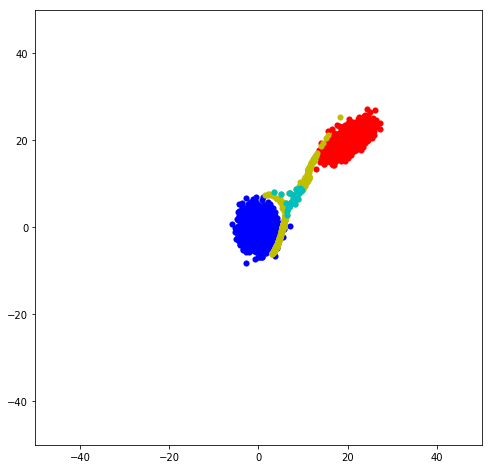

In [23]:
_generator.eval()
_predictor.eval()
fix_noises = Variable(torch.randn(500, n_noise_fea))
with torch.no_grad():
    fake_data = _generator(fix_noises).detach()
    p = _predictor(fake_data)
    p = F.softmax(p, dim=-1)
    fake_data = fake_data.cpu().data
  
    p = np.max(p.cpu().numpy(), axis=1)
    X_highpro = fake_data[(p > 0.5) & (p < 0.6)]
    plt.figure(figsize=[8,8])
    plt.ylim(-50, 50)
    plt.xlim(-50, 50)
    plt.scatter(X_train1[:,0], X_train1[:,1], c='b', linewidth=0.1)
    plt.scatter(X_train2[:,0], X_train2[:,1], c='r', linewidth=0.1)
    plt.scatter(fake_data[:,0], fake_data[:,1], c='y', linewidth=0.1)
    plt.scatter(X_highpro[:,0], X_highpro[:,1], c='c', linewidth=0.1)

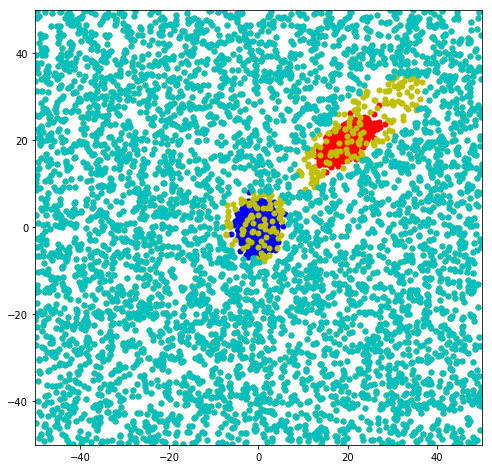

In [12]:
Test_data = dataload(mode = 'test')
Test_dataloader = DataLoader(dataset=Test_data, batch_size = 5000, shuffle=False)

_predictor.eval()   
with torch.no_grad():
    for data, classes in (Test_dataloader):

        labels = classes.cuda()
        data = data.cuda().float()
        a = _predictor(data)

        p_class = F.softmax(a, dim=-1)
    
p = np.max(p_class.cpu().numpy(), axis=1)
X_highpro = X_test[(p > 0.5) & (p < 0.6)]

plt.figure(figsize=[8,8])
plt.ylim(-50, 50)
plt.xlim(-50, 50)
plt.scatter(X_train1[:,0], X_train1[:,1], c='b', linewidth=0.1)
plt.scatter(X_train2[:,0], X_train2[:,1], c='r', linewidth=0.1)
plt.scatter(X_test[:,0], X_test[:,1], c='y', linewidth=0.1)
plt.scatter(X_highpro[:,0], X_highpro[:,1], c='c', linewidth=0.1)
plt.show()
